In [1]:
import os
import pickle
import numpy
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
#tf.config.experimental.set_memory_growth(physical_devices[1], enable=True)
from music21 import note, chord

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.utils import plot_model

from models.RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

In [2]:
#tf.config.list_physical_devices('GPU')

In [3]:
# run params
section = 'compose'
run_id = '0003'
music_name = 'cello2'

run_folder = 'run/{}/'.format(section)
run_folder += '_'.join([run_id, music_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join('data', music_name)

if not os.path.exists(run_folder):
    os.mkdir(run_folder)
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

In [4]:
%%time
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f)

1 files in total
1 Parsing data/cello2/cs2-1pre.mid
CPU times: user 1.07 s, sys: 12.8 ms, total: 1.08 s
Wall time: 1.08 s


In [5]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [6]:
print('\nnote_to_int')
len(note_to_int)
#note_to_int


note_to_int


39

In [7]:
print('\nduration_to_int')
len(duration_to_int)
#duration_to_int


duration_to_int


7

In [8]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [9]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38 38
 38 38 38 38 38 38 38 38]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
duration output
[0. 0. 1. 0. 0. 0. 0.]


In [10]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    3900        input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    700         input_2[0][0]                    
______________________________________________________________________________________________

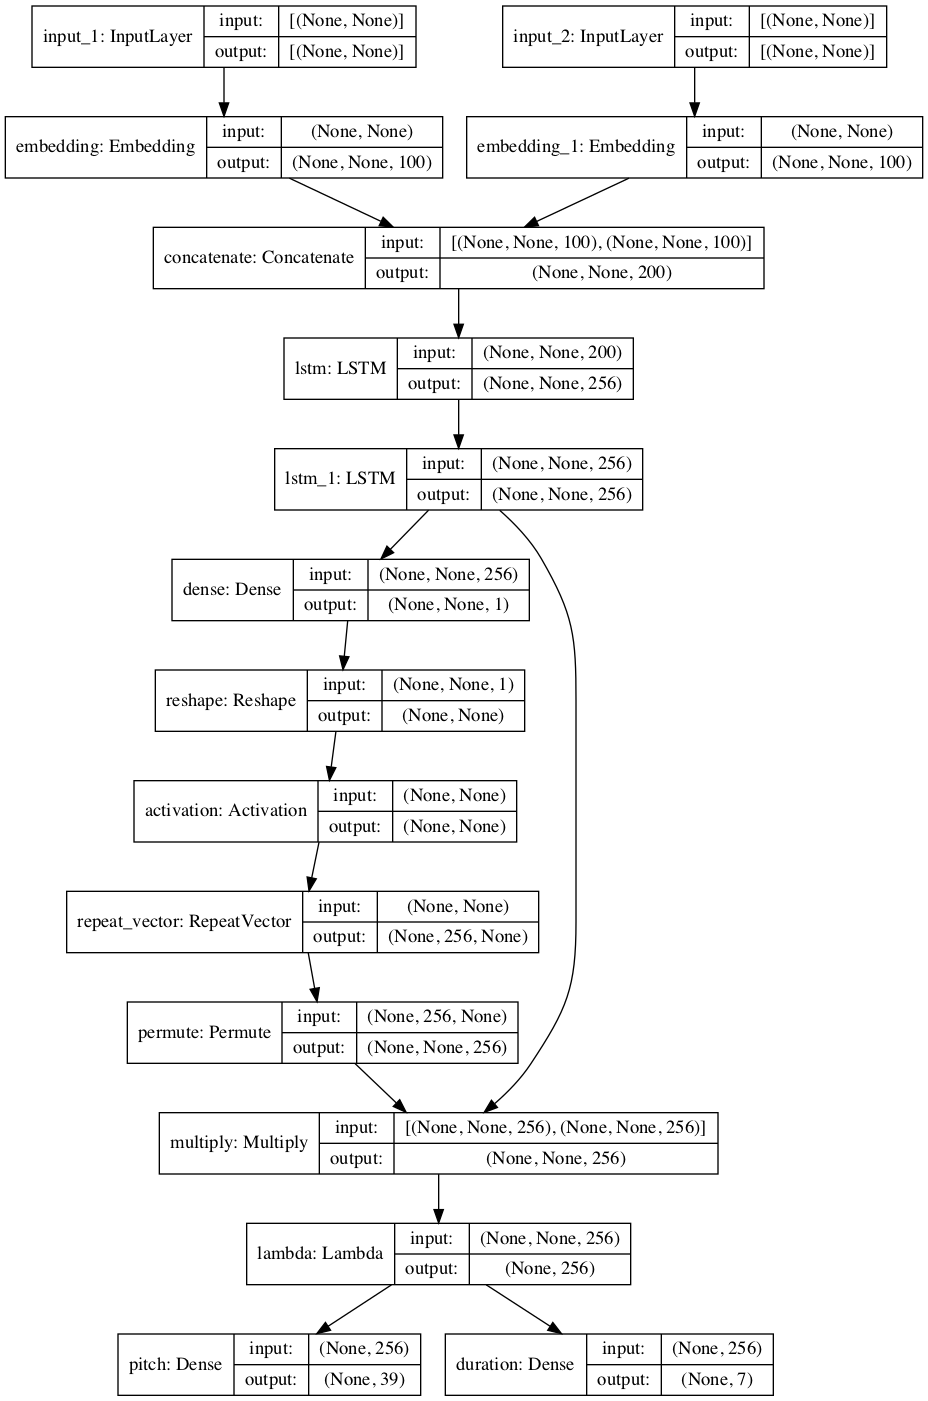

In [11]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

In [12]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [14]:
weights_folder = os.path.join(run_folder, 'weights')
'''
checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)
'''

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    #checkpoint1
     checkpoint2
    , early_stopping
 ]


model.fit(network_input, network_output
          , epochs=20000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )
model.save_weights(os.path.join(weights_folder, "weights.h5"))

Epoch 1/20000
16/16 [==============================] - 2s 100ms/step - loss: 2.3894 - pitch_loss: 2.2164 - duration_loss: 0.1729 - val_loss: 5.7531 - val_pitch_loss: 4.9017 - val_duration_loss: 0.8514
Epoch 2/20000
16/16 [==============================] - 2s 99ms/step - loss: 2.3250 - pitch_loss: 2.1661 - duration_loss: 0.1589 - val_loss: 5.6375 - val_pitch_loss: 4.8430 - val_duration_loss: 0.7944
Epoch 3/20000
16/16 [==============================] - 2s 106ms/step - loss: 2.2839 - pitch_loss: 2.1427 - duration_loss: 0.1412 - val_loss: 5.5709 - val_pitch_loss: 4.6919 - val_duration_loss: 0.8790
Epoch 4/20000
16/16 [==============================] - 2s 104ms/step - loss: 2.2702 - pitch_loss: 2.1236 - duration_loss: 0.1466 - val_loss: 5.6902 - val_pitch_loss: 4.8434 - val_duration_loss: 0.8468
Epoch 5/20000
16/16 [==============================] - 2s 98ms/step - loss: 2.2251 - pitch_loss: 2.0765 - duration_loss: 0.1486 - val_loss: 5.6349 - val_pitch_loss: 4.8395 - val_duration_loss: 0.79

Epoch 42/20000
16/16 [==============================] - 2s 116ms/step - loss: 0.7738 - pitch_loss: 0.7276 - duration_loss: 0.0462 - val_loss: 8.6912 - val_pitch_loss: 7.1914 - val_duration_loss: 1.4998
Epoch 43/20000
16/16 [==============================] - 2s 103ms/step - loss: 0.7701 - pitch_loss: 0.7270 - duration_loss: 0.0430 - val_loss: 8.2910 - val_pitch_loss: 6.9341 - val_duration_loss: 1.3569
Epoch 44/20000
16/16 [==============================] - 2s 113ms/step - loss: 0.6967 - pitch_loss: 0.6560 - duration_loss: 0.0408 - val_loss: 8.5181 - val_pitch_loss: 7.0170 - val_duration_loss: 1.5011
Epoch 45/20000
16/16 [==============================] - 2s 103ms/step - loss: 0.7148 - pitch_loss: 0.6716 - duration_loss: 0.0432 - val_loss: 8.9274 - val_pitch_loss: 7.4967 - val_duration_loss: 1.4307
Epoch 46/20000
16/16 [==============================] - 2s 110ms/step - loss: 0.6830 - pitch_loss: 0.6445 - duration_loss: 0.0385 - val_loss: 8.4744 - val_pitch_loss: 6.9932 - val_duration_los

16/16 [==============================] - 2s 107ms/step - loss: 0.3210 - pitch_loss: 0.2833 - duration_loss: 0.0377 - val_loss: 9.3930 - val_pitch_loss: 7.7853 - val_duration_loss: 1.6077
Epoch 83/20000
16/16 [==============================] - 2s 108ms/step - loss: 0.2978 - pitch_loss: 0.2712 - duration_loss: 0.0266 - val_loss: 9.1911 - val_pitch_loss: 7.6370 - val_duration_loss: 1.5541
Epoch 84/20000
16/16 [==============================] - 2s 117ms/step - loss: 0.2691 - pitch_loss: 0.2441 - duration_loss: 0.0250 - val_loss: 9.7276 - val_pitch_loss: 8.1822 - val_duration_loss: 1.5454
Epoch 85/20000
16/16 [==============================] - 2s 100ms/step - loss: 0.2569 - pitch_loss: 0.2336 - duration_loss: 0.0233 - val_loss: 9.5647 - val_pitch_loss: 8.0288 - val_duration_loss: 1.5359
Epoch 86/20000
16/16 [==============================] - 2s 105ms/step - loss: 0.3051 - pitch_loss: 0.2842 - duration_loss: 0.0209 - val_loss: 9.9388 - val_pitch_loss: 8.3688 - val_duration_loss: 1.5701
Epoch

16/16 [==============================] - 2s 112ms/step - loss: 0.2225 - pitch_loss: 0.1858 - duration_loss: 0.0367 - val_loss: 10.3574 - val_pitch_loss: 8.6081 - val_duration_loss: 1.7492


In [15]:
model.save_weights(os.path.join(weights_folder, "weights.h5"))